In [222]:
import pandas as pd
import tensorflow as tf
import numpy as np
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

In [130]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [243]:
print(train.shape, test.shape)
train.head()

(30000, 394) (10000, 394)


,X000,X001,X002,X003,X004,X005,X006,X007,X008,X009,...,X384,X385,X386,X387,X388,X389,X390,X391,X392,Y
0,0.435294,0.568627,0.470588,0.239216,0.062745,0.003922,0.000000,0.000000,0.133333,0.321569,...,0.694118,0.000000,0.000000,0.000000,0.000000,0.000000,0.054902,0.243137,0.537255,5
1,0.290196,0.192157,0.098039,0.039216,0.011765,0.000000,0.000000,0.000000,0.482353,0.627451,...,0.278431,0.007843,0.019608,0.035294,0.054902,0.082353,0.133333,0.141176,0.098039,0
2,0.000000,0.000000,0.000000,0.000000,0.003922,0.027451,0.082353,0.184314,0.000000,0.000000,...,0.380392,0.007843,0.050980,0.164706,0.301961,0.400000,0.443137,0.415686,0.360784,4
3,0.745098,0.952941,0.870588,0.329412,0.035294,0.000000,0.000000,0.000000,0.000000,0.058824,...,0.000000,0.015686,0.211765,0.341176,0.800000,0.101961,0.000000,0.000000,0.000000,1
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9


In [10]:
train["Y"].unique() # check number of labels

array([5, 0, 4, 1, 9, 2, 3, 6, 7, 8])

In [162]:
# Should shuffle the examples too
val_split = 0.1
val_num = int(len(train) * val_split)

val_x = train.iloc[:val_num, 1:393].to_numpy()
val_y = train.iloc[:val_num, 393:394].to_numpy()
train_x = train.iloc[val_num:, 1:393].to_numpy()
train_y = train.iloc[val_num:, 393:394].to_numpy()
test_x = test.iloc[:, 1:393].to_numpy()
test_y = test.iloc[:, 393:394].to_numpy()
print(train_x.shape, train_y.shape)

(27000, 392) (27000, 1)


In [239]:
class BaseModel:
    # might be neater to subclass the keras model class
    def __init__(self, layers: list):
        self.layers = []
        for layer in layers:
            if layer[0] == "dense":
                self.layers.append(tf.keras.layers.Dense(layer[1], activation=layer[2]))
            elif layer[0] == "dropout":
                self.layers.append(tf.keras.layers.Dropout(layer[1]))
        self.model = tf.keras.models.Sequential(self.layers)
    
    
    def train(self, train_data, val_data, parameters):
        """Takes in train and validation data as well as a class of hyper-parameters"""
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=parameters.patience)
        
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=parameters.learning_rate),
            loss=loss_fn,
            metrics=['accuracy'],
            )
        
        history = self.model.fit(*train_data, validation_data=val_data, epochs=parameters.epochs, callbacks=[callback])
        print(history)
        return history

    def predict(self, x, labels=True):
        if labels:
            return np.argmax(self.model.predict(x), axis=1)
        return self.model.predict(x)
            
    
class Ensemble:
    """Class for ensemble of models. Trains each model separately. Takes the majority vote for prediction."""
    def __init__(self, models: list):
        self.models = models
    
    def train(self, train_data: tuple, val_data: tuple, parameters: list):
        for i, (model, params) in enumerate(zip(self.models, parameters)):
            print(f"Training model {i + 1}")
            history = model.train(train_data, val_data, params)
            plot_losses(history["losses"])

    
    def predict(self, data):
        preds = []
        for model in self.models:
            preds.append(model.predict(data))
        preds = np.asarray(preds)
        return mode(preds, 0).mode # take majority vote class label

    def evaluate(self, x, y):
        preds = self.predict(x)
        accuracy = accuracy_score(y.flatten(), preds.flatten())
        return accuracy


class Parameters:
    """Useful object for storing model parameters."""
    def __init__(self, epochs=3, learning_rate=1e-3, patience=2):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.patience = patience


def plot_losses(losses, val_losses):
    epochs = list(range(1, len(losses) + 1))
    plt.plot(epochs, losses, label="train_loss")
    plt.plot(epochs, val_losses, label="val_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(loc="upper right")
    plt.show()

In [240]:
# Try out 5 different models
models = [
    BaseModel([("dense", 64, "relu"), ("dropout", 0.1), ("dense", 10, "softmax")]),
    BaseModel([("dense", 128, "relu"), ("dropout", 0.2), ("dense", 10, "softmax")]),
    BaseModel([("dense", 128, "relu"), ("dense", 64, "relu"), ("dense", 10, "softmax")]),
    BaseModel([("dense", 256, "relu"), ("dropout", 0.2), ("dense", 128, "relu"), ("dropout", 0.2), ("dense", 10, "softmax")]),
    BaseModel([("dense", 128, "gelu"), ("dropout", 0.2), ("dense", 128, "gelu"), ("dropout", 0.2), ("dense", 10, "softmax")])
]
parameters = [
    Parameters(5, 4e-3),
    Parameters(3, 1e-3), 
    Parameters(4, 2e-4, 3),
    Parameters(4, 2e-3, 3),
    Parameters(10, 3e-3, 3)
    ]

Training model 1
Epoch 1/5
844/844 [==============================] - 1s 655us/step - loss: 1.1580 - accuracy: 0.6095 - val_loss: 0.8108 - val_accuracy: 0.7493
Epoch 2/5
844/844 [==============================] - 0s 587us/step - loss: 0.8353 - accuracy: 0.7274 - val_loss: 0.7143 - val_accuracy: 0.7840
Epoch 3/5
844/844 [==============================] - 0s 581us/step - loss: 0.7621 - accuracy: 0.7507 - val_loss: 0.6580 - val_accuracy: 0.7937
Epoch 4/5
844/844 [==============================] - 0s 583us/step - loss: 0.7179 - accuracy: 0.7633 - val_loss: 0.6263 - val_accuracy: 0.8090
Epoch 5/5
844/844 [==============================] - 0s 581us/step - loss: 0.6897 - accuracy: 0.7746 - val_loss: 0.6091 - val_accuracy: 0.8177


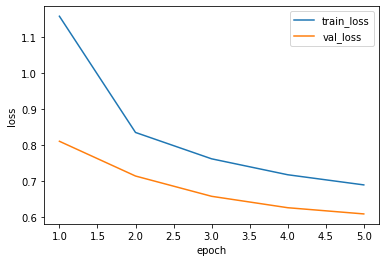

Training model 2
Epoch 1/3
844/844 [==============================] - 1s 697us/step - loss: 1.2279 - accuracy: 0.5914 - val_loss: 0.8401 - val_accuracy: 0.7630
Epoch 2/3
844/844 [==============================] - 1s 630us/step - loss: 0.8090 - accuracy: 0.7475 - val_loss: 0.6444 - val_accuracy: 0.8173
Epoch 3/3
844/844 [==============================] - 1s 673us/step - loss: 0.6814 - accuracy: 0.7893 - val_loss: 0.5705 - val_accuracy: 0.8377


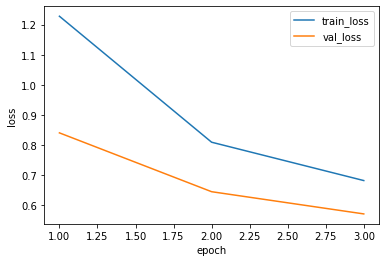

Training model 3
Epoch 1/4
844/844 [==============================] - 1s 848us/step - loss: 1.4928 - accuracy: 0.5140 - val_loss: 1.1564 - val_accuracy: 0.6330
Epoch 2/4
844/844 [==============================] - 1s 727us/step - loss: 1.0066 - accuracy: 0.6941 - val_loss: 0.8911 - val_accuracy: 0.7427
Epoch 3/4
844/844 [==============================] - 1s 717us/step - loss: 0.8068 - accuracy: 0.7616 - val_loss: 0.7400 - val_accuracy: 0.7893
Epoch 4/4
844/844 [==============================] - 1s 725us/step - loss: 0.6880 - accuracy: 0.7961 - val_loss: 0.6636 - val_accuracy: 0.8107


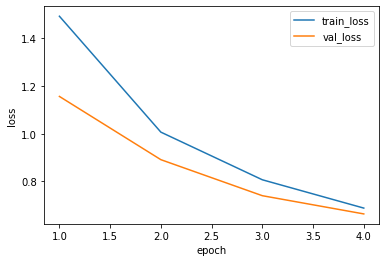

Training model 4
Epoch 1/4
844/844 [==============================] - 1s 1ms/step - loss: 1.0741 - accuracy: 0.6356 - val_loss: 0.6207 - val_accuracy: 0.8163
Epoch 2/4
844/844 [==============================] - 1s 1ms/step - loss: 0.6612 - accuracy: 0.7890 - val_loss: 0.4966 - val_accuracy: 0.8410
Epoch 3/4
844/844 [==============================] - 1s 999us/step - loss: 0.5523 - accuracy: 0.8259 - val_loss: 0.4269 - val_accuracy: 0.8723
Epoch 4/4
844/844 [==============================] - 1s 997us/step - loss: 0.4798 - accuracy: 0.8450 - val_loss: 0.4274 - val_accuracy: 0.8673


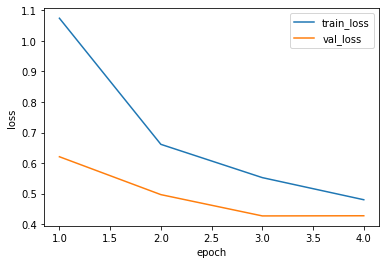

Training model 5
Epoch 1/10
844/844 [==============================] - 1s 963us/step - loss: 1.0497 - accuracy: 0.6419 - val_loss: 0.6247 - val_accuracy: 0.8027
Epoch 2/10
844/844 [==============================] - 1s 883us/step - loss: 0.6898 - accuracy: 0.7759 - val_loss: 0.5201 - val_accuracy: 0.8330
Epoch 3/10
844/844 [==============================] - 1s 900us/step - loss: 0.5948 - accuracy: 0.8059 - val_loss: 0.5040 - val_accuracy: 0.8410
Epoch 4/10
844/844 [==============================] - 1s 902us/step - loss: 0.5494 - accuracy: 0.8225 - val_loss: 0.4515 - val_accuracy: 0.8650
Epoch 5/10
844/844 [==============================] - 1s 894us/step - loss: 0.5237 - accuracy: 0.8314 - val_loss: 0.4450 - val_accuracy: 0.8633
Epoch 6/10
844/844 [==============================] - 1s 888us/step - loss: 0.5000 - accuracy: 0.8396 - val_loss: 0.4191 - val_accuracy: 0.8720
Epoch 7/10
844/844 [==============================] - 1s 891us/step - loss: 0.4751 - accuracy: 0.8449 - val_loss: 0.397

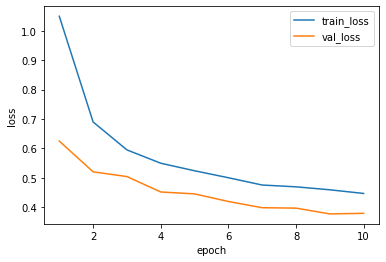

In [241]:
ensemble = Ensemble(models)
ensemble.train((train_x, train_y), (val_x, val_y), parameters)

In [242]:
val_acc = ensemble.evaluate(val_x, val_y)
test_acc = ensemble.evaluate(test_x, test_y)
print(f"Val acc: {val_acc}, test acc: {test_acc}")

Val acc: 0.873, test acc: 0.7362
